# Lab 4 #
Tianhao Jiang

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import statistics
import h5py
import warnings
import xarray as xr
from scipy import stats
from scipy.optimize import curve_fit

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

## Problem 1 ##

The goal is to explore the relationship among the data's attributes and to calculate the time-depend background observed by the  gamma-ray satellite.

Import the data:

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
# hf.keys()
hf.close()

In [3]:
print("The data set has %d data points." % len(data[0]))
print("Data is recorded in %.2f days." % ((data[0,len(data[0])-1]-data[0,0])/3600/24)  )
print("Data has a time step of %.2f seconds." % (data[0,2] - data[0,1]))

The data set has 25920001 data points.
Data is recorded in 30.00 days.
Data has a time step of 0.10 seconds.


The data has 4 attributes:

* time (in gps seconds)

* Solar phase (deg) showing the position of the sun relative to the orbit,

* Earth longitude (deg) giving the position of the spacecraft relative to the ground

* particle counts

As the first step, we should plot the last 3 attributes as functions of time to see how they relate to each other.

We know the Earth longitude and the Solar phase as a function of time has periods about 90 minutes. And the data has a time span of 30 day, which is 720 hours and corresponds to about 480 periods. So if we plot all the data in the same graph, the plot would look like a blob and wouldn't show any useful trend. 

Thus I decided to plot subplots of the data that include only a few periods of Solar phase and Earth longitude. 

Below I plotted two subsets of the data that each corresponds 10 hours on the satellite starting from 100 and 600 hours, respectively. The particle counts were plotted as 2D histograms.

In [4]:
def plot_data(start_hour, hour_span):
    time = start_hour*36000 + np.array(range(0,hour_span*36000)) # in milliseconds
    fig, ax1 = plt.subplots(1, 1)

    h = ax1.hist2d(time/36000,data[3,time], bins=[100,26],cmap = "RdYlGn_r")
    ax1.set_ylabel("Particle Count", fontsize = 15)
    ax1.set_xlabel("Time (seconds)", fontsize = 15)
    fig.colorbar(h[3])

    ax2 = ax1.twinx()
    line1, = ax2.plot(time/36000,data[1,time], 'k', label='Solar phase (deg)',linewidth = 4,alpha = 0.7)
    line2, = ax2.plot(time/36000,data[2,time], 'b', label='Earth longitude (deg)',linewidth = 4,alpha = 0.7)
    ax2.legend(loc='upper right', fontsize = 15)
    ax2.set_ylabel("Degrees", fontsize = 15)
    plt.title("Data From %.1f Hour to %.1f Hour" % (start_hour,start_hour + hour_span), fontsize = 15)
    plt.show()



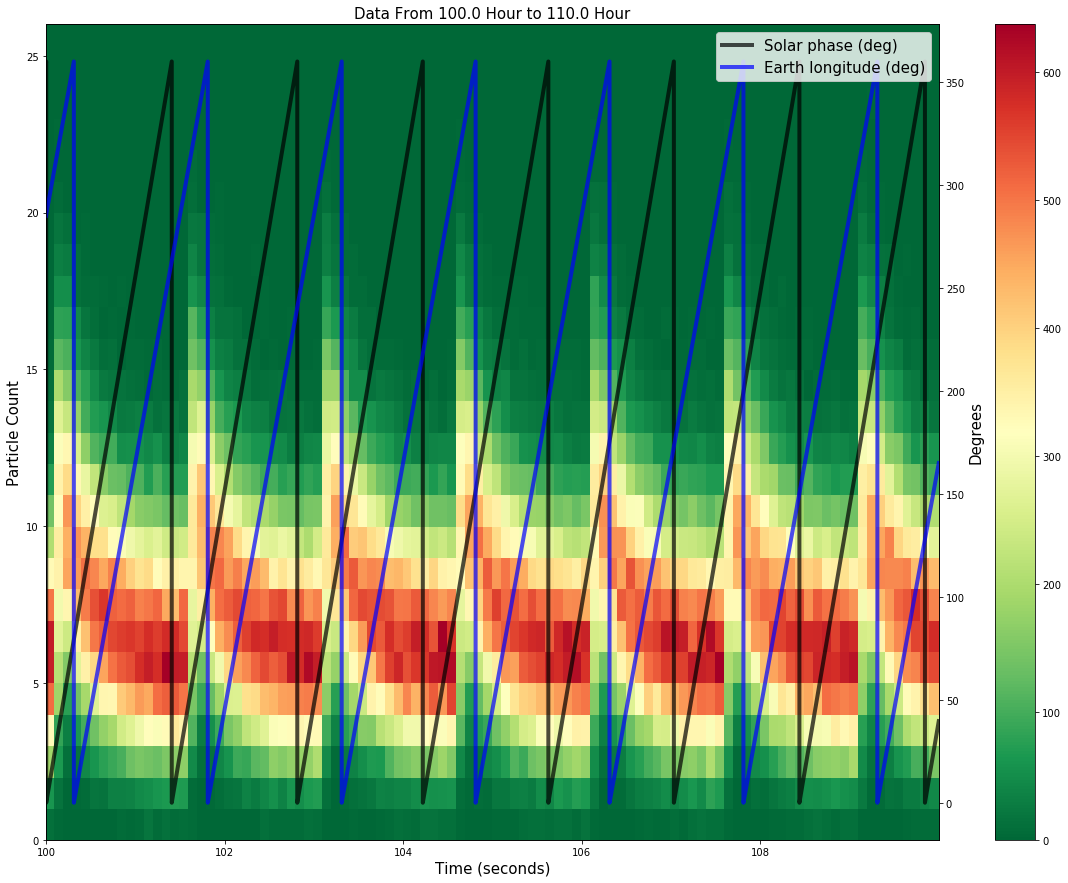

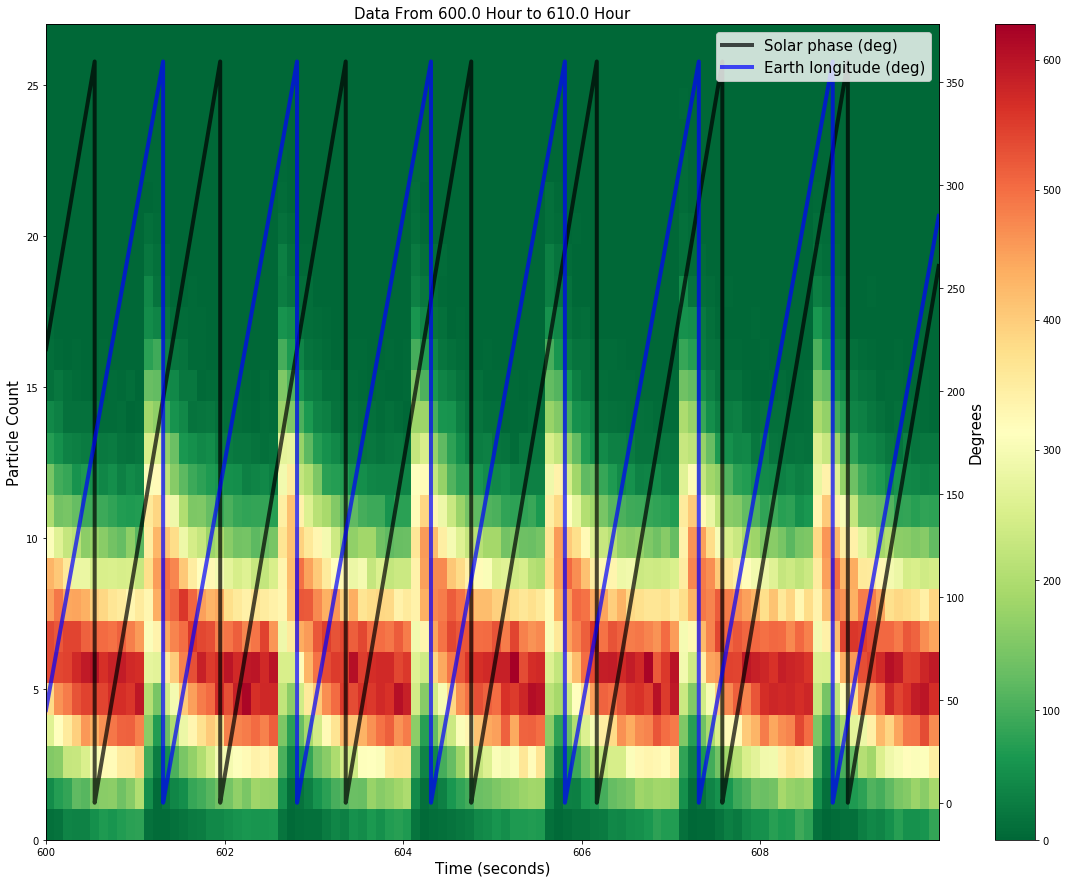

In [5]:
plot_data(100,10)
plot_data(600,10)

As shown, the Solar phase, the Earth's longitude, and the particle counts all seem to have a period of about 1.5 hours. The Solar phase and the Earth's longitude both increase linearly with time but have slightly different periods. In both graphs, the histogram of the particle counts seems to have the same period as the Earth's longitude, with its mean decreasing as a function of time in each of its periods.

It's thus natural to assume that the particle counts depend on the Earth's longitude but not on the the Solar phase. To see the dependences more clearly, I plotted the 2D histograms of the particle counts as functions of longitude and Solar phase:

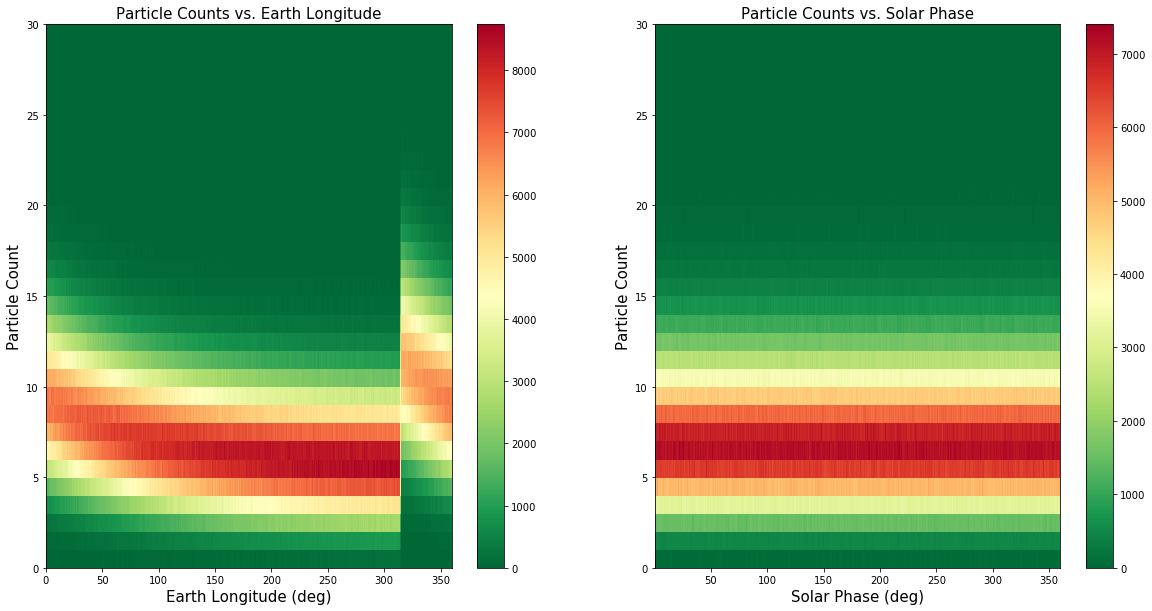

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=2)

h1 = ax[0].hist2d(data[2],data[3], bins=[500,30],cmap = "RdYlGn_r")
ax[0].set_ylabel("Particle Count", fontsize = 15)
ax[0].set_xlabel("Earth Longitude (deg)", fontsize = 15)
fig.colorbar(h1[3], ax = ax[0])
ax[0].set_title("Particle Counts vs. Earth Longitude", fontsize = 15)


h2 = ax[1].hist2d(data[1],data[3], bins=[500,30],cmap = "RdYlGn_r")
ax[1].set_ylabel("Particle Count", fontsize = 15)
ax[1].set_xlabel("Solar Phase (deg)", fontsize = 15)
fig.colorbar(h2[3],ax = ax[1])
ax[1].set_title("Particle Counts vs. Solar Phase", fontsize = 15)
fig.figsize = (20,5)
plt.show()


As shown by the graph at the left, when plotted against the Earth's longitude, the particle counts has a clear decreasing trend from 0 degree to about 315 degrees as well as from 315 degrees to 360 degrees. On the other hand, the right graph shows that the counts' histogram appears to be constant when solar phase changes.

So it should be safe to say that the counts depend on the Earth's longitude but not on the Solar phase. 

The goal is to find how the particle counts depend on time. Since the counts depend on the longitude, we know that the counts and the longitude should have the same period. So we can find the counts' period by finding the period of the longitude:

In [7]:
length = len(data[0])
indices = np.array([0]*int(length/80/60/10))
steps = set()
j = -1;
for i in range(1,len(data[0])):
    if abs(data[2,i]-data[2,i-1]) > 300:
        j = j + 1
        indices[j] = i
        if j > 0:
            steps.add(i-indices[j-1])
indices = indices[0:j]
#print(len(indices))
print("Set of number of data points between adjacent local maximum Earth longitudes:")
print(steps)

Set of number of data points between adjacent local maximum Earth longitudes:
{54000}


So there are 54000 data points in each cycle of Earth lognitude, which corresponds to 5400 seconds or exactly 90 minutes.

To see how the counts relate to time, folded the time attribute of the data at the 5400 seconds period and chose a specific starting time (data[0,40500]) for the folded time so that the counts would have a monotomically decreasing trend when plotted as a function of it.

In [8]:
period = 5400
t_folded = np.round(np.mod(data[0]-data[0,40500], period), 4)

Calculate the mean particle counts as a function of folded time:

In [9]:
dt = 15
t_span = np.arange(0,5400+dt,dt)
avg_counts = np.array([0.]*(len(t_span)-1))
#print(len(avg_counts))
for i in range(0,len(t_span)-1):
    counts = data[3][(t_folded >= t_span[i]) & (t_folded < t_span[i+1])]
    avg_counts[i] = sum(counts)/len(counts)

t_span = np.delete(t_span, len(t_span)-1)

Plot the mean counts and histogram of counts as a function of folded time:

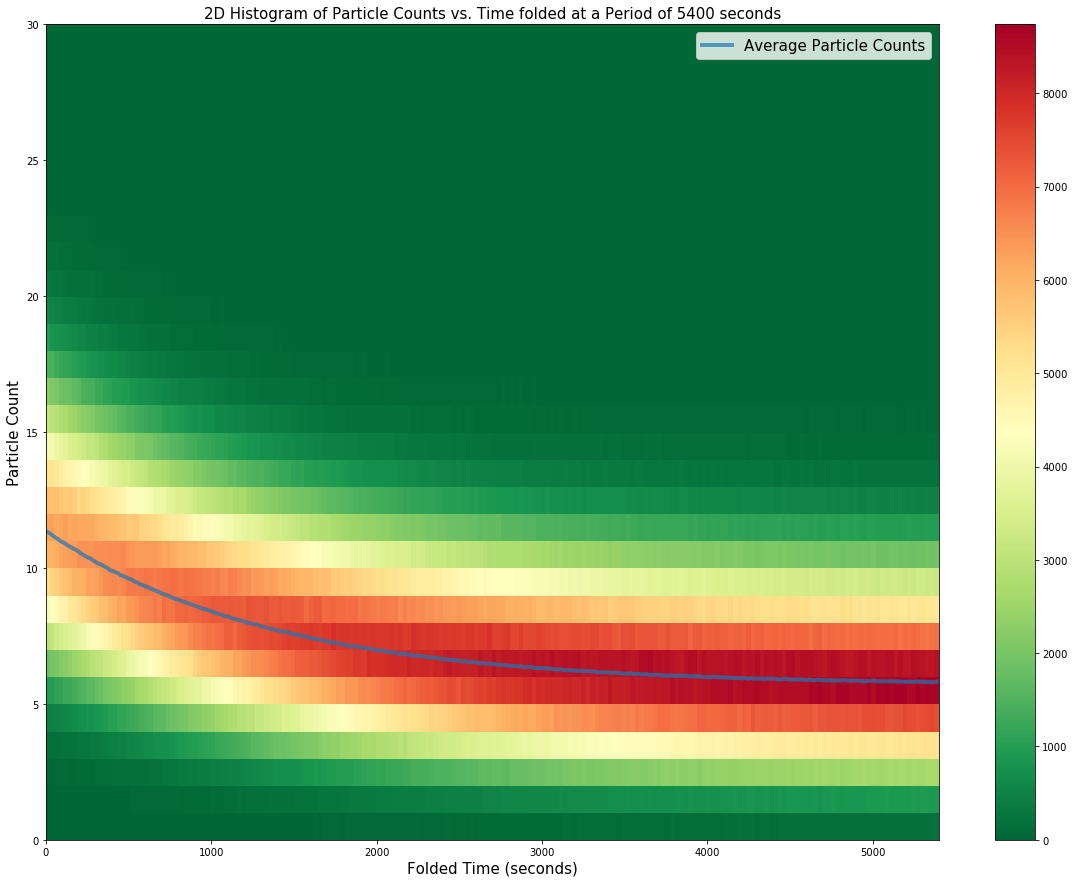

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20,15))
line, = ax.plot(t_span, avg_counts, label='Average Particle Counts', linewidth = 4, alpha = 0.7)
ax.legend(loc='upper right', fontsize = 15)
[h, xedges, yedges, image] = ax.hist2d(t_folded,data[3], bins=[200,30],cmap = "RdYlGn_r")
ax.set_ylabel("Particle Count", fontsize = 15)
ax.set_xlabel("Folded Time (seconds)", fontsize = 15)
fig.colorbar(h1[3], ax = ax)
ax.set_title("2D Histogram of Particle Counts vs. Time folded at a Period of 5400 seconds", fontsize = 15)
plt.show()

The curve of mean particle counts vs folded time looks like an elevated exponential function, so I guess its mathematical expression may has the form of 
$$
a \cdot e^{-bt} + c,
$$
where $t$ is the folded time in seconds and a, b, and c are unknown positive values. 

Fitting this function to the curve of the mean counts, we get:

In [11]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
warnings.filterwarnings("ignore")
popt, pcov = curve_fit(func, t_span, avg_counts)
warnings.filterwarnings("default")
print("[a b c] = %s" % str(popt))

[a b c] = [5.66291086e+00 7.39896527e-04 5.69830561e+00]


Plot the fitted curve using these parameters and compare to data:

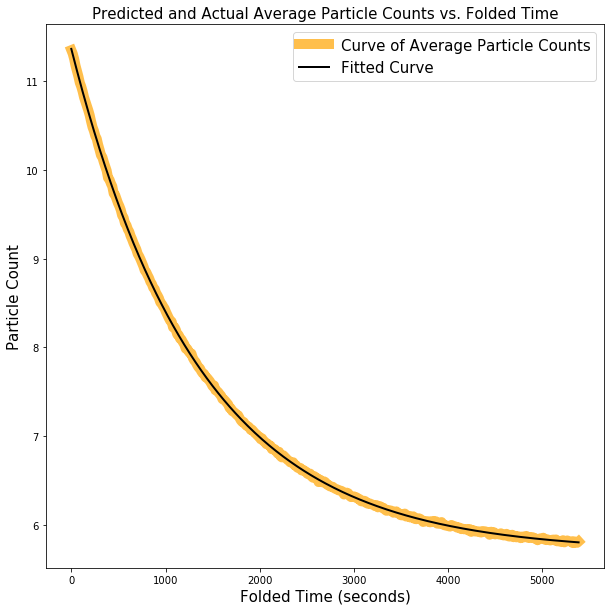

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
line1, = ax.plot(t_span, avg_counts,'orange',label='Curve of Average Particle Counts',linewidth = 10,alpha = 0.7)
line2, = ax.plot(t_span, func(t_span, *popt), 'k',label='Fitted Curve',linewidth = 2)
ax.legend(loc='upper right', fontsize = 15)

ax.set_ylabel("Particle Count", fontsize = 15)
ax.set_xlabel("Folded Time (seconds)", fontsize = 15)
ax.set_title("Predicted and Actual Average Particle Counts vs. Folded Time", fontsize = 15)
plt.show()

The fitted curve and the curve of the original data overlaps perfectly. So the function 
$$
\hat{\lambda}(t) = a \cdot e^{-bt} + c
$$
with [a b c] = [5.66291086e+00 7.39896527e-04 5.69830561e+00] should be a good model for the average number of counts as a function of folded time.

Finally we need to determine how the distribution of the counts depend on time. Intuitively I assumed the distribution at a give folded time t should follow a Poisson distribution with it's parameter given by $\hat{\lambda}(t)$. To see if this is true, I plotted the distributions of the particle counts and the corresponding Poisson distributions at 3 different folded times.

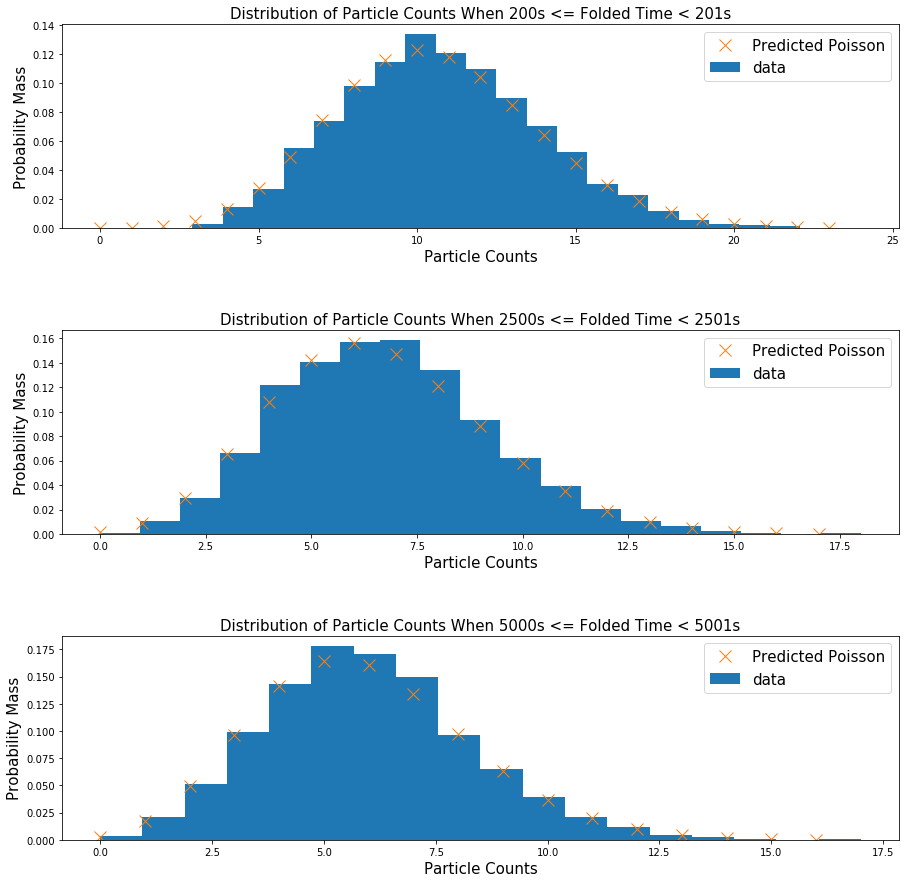

In [13]:
times = np.array([200, 2500, 5000])

fig, ax = plt.subplots(len(times), 1, figsize=(15,5*len(times)))
plt.subplots_adjust(hspace=.5)
for i in range(0,len(times)):
    time = times[i]
    counts = data[3][(t_folded >= times[i]) & (t_folded < times[i] + 1)]
    ax[i].hist(counts, bins = int(np.max(counts)-np.min(counts)+1), density=True, label='data')
    x = range(0,np.int(max(counts)))
    y=stats.poisson.pmf(x,func(time, *popt))
    ax[i].plot(x,y,'x',markersize=12, label='Predicted Poisson')
    ax[i].legend(prop={'size': 15})
    ax[i].set_ylabel("Probability Mass", fontsize = 15)
    ax[i].set_xlabel("Particle Counts", fontsize = 15)
    ax[i].set_title("Distribution of Particle Counts When %ds <= Folded Time < %ds" % (time, time + 1), fontsize = 15)
plt.show()

As shown, the predicted values are quite close the the actual data. So the particle counts at a given time should follow a Poisson distribution.

We can then calculate the '5-sigma' threshold for a 100-millisecond gamma-ray bursts as a function of the folded time by first finding the probability corresponding to 5-sigma and then plugging the probability into the PPF of a Poisson distribution with its parameter given by $\hat{\lambda}(t)$:

In [14]:
dt2 = 0.1
t2_span = np.arange(0,5400,dt2)
counts = np.array([0]*len(t2_span))
prob = stats.norm.cdf(5)
for i in range(0,len(t2_span)):
    counts[i] = stats.poisson.ppf(prob,func(t2_span[i], *popt))

Plot the result:

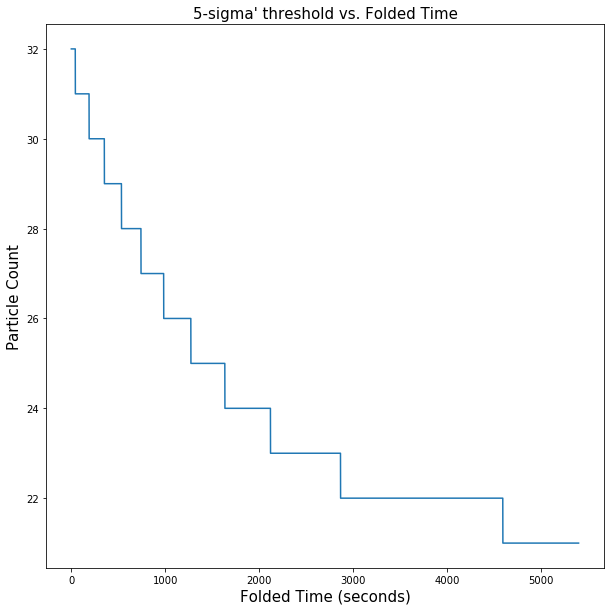

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylabel("Particle Count", fontsize = 15)
ax.set_xlabel("Folded Time (seconds)", fontsize = 15)
ax.set_title("5-sigma' threshold vs. Folded Time", fontsize = 15)
plt.plot(t2_span,counts)
plt.show()

The above functions are derived with the folded time $t_{\text{folded}}$. If, instead, the actual time $t$ is needed, we can use the relation
\begin{align}
 t_{\text{folded}} =& (t - \text{data[0,40500]}) \text{ mod } 5400\\
 =& (t - 940684066.0) \text{ mod } 5400
\end{align}
to replace $t_{\text{folded}}$ with $t$.

I think the time dependence of the background particle counts may be a result of the influence of the South Atlantic Anomaly (SAA). According to Wikipedia, the SAA is an area on Earth with a high flux of energetic particles. If the (simulated) satellite is orbiting along the equator when recording the data, then the longitude the satellite when it intersects the SAA would be almost exactly 315 degrees, which is the same as the longitude at which the sudden increase of average particle counts happens in the data. My guess is that some radioactive particles would always stick to the satellite when the satellite passes through the SAA. The particles that the satellite detects would then come from both the constant cosmic ray background and the radiation of the exponentially decaying stuck particles. This could explain why the average count of particles as a function of folded time follows the scheme of $\hat{\lambda}(t) = a \cdot e^{-bt} + c$.

In [16]:
1/7.39896527e-04*np.log(2) # expected half-life of stuck particles

936.816372649287

The value of the parameter $b$ I found was 7.39896527e-04, which corresponds to a half-life of $\ln(2) / 7.39896527^{-04}=936.8$ seconds. But I didn't find any isotope with this exact half-life on the web. So I'm not perfectly confident with my theory.

## Problem 2 ##

My task is to identify a transient event from 10 (simulated) telescope images.

Import the images:

In [17]:
hf = h5py.File('images.h5', 'r')
#print(hf.keys())
imagestack = np.array(hf.get('imagestack'))
hf.close()

print("shape of data: %s" % str(imagestack.shape))

shape of data: (200, 200, 10)


Images are plotted below. The color bar gives the brightness of the pixels as a function of their shown color.

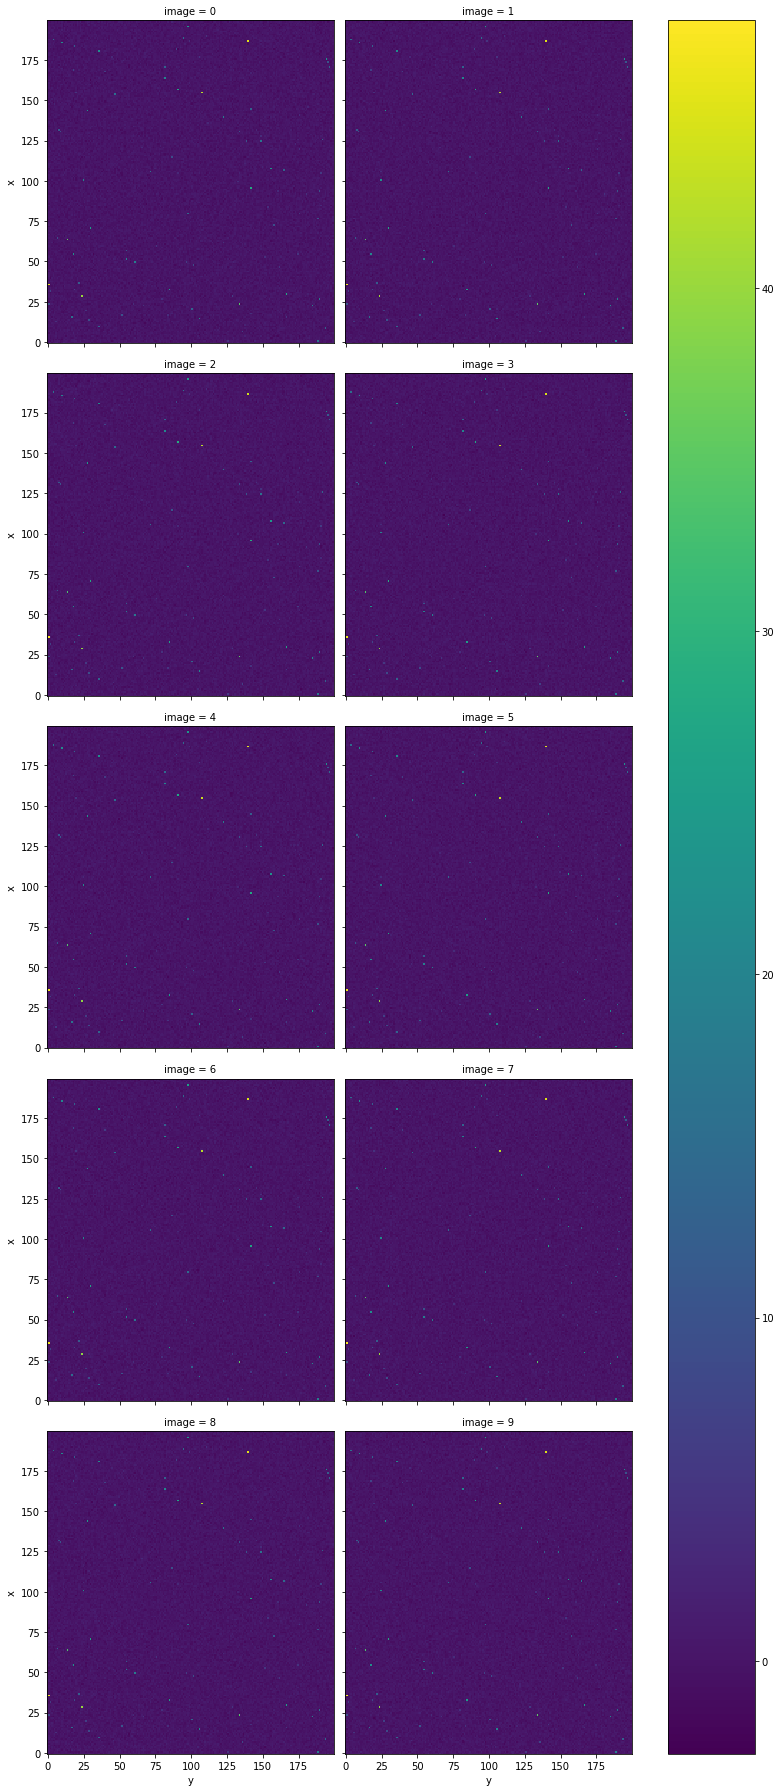

In [19]:
stack = xr.DataArray(imagestack, dims=['x', 'y', 'image']).transpose('image','x','y')
stack.plot(center=False, col='image', col_wrap=2, size=5)
plt.show()

The locations of the bright spots looks consistant across the images. So I will assume these are images of the same location on the sky taken in a s rather short period of time. 

Before determining the background when look for the transient, I first need to examine the background when looking for normal stars. 

Plot histograms brightnesses for different images: 

In [15]:
def image_hist(i):
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    ax[0].hist(imagestack[:,:,i].flatten(),bins=200)
    #ax.set_yscale("log")
    ax[1].hist(imagestack[:,:,i].flatten(),bins=200)
    ax[1].set_yscale("log")
    ax[0].set_xlabel("brightness",fontsize = 15)
    ax[0].set_ylabel("number of pixels",fontsize = 15)
    ax[0].set_title("Image %d, Brightness Histogram" % i,fontsize = 15)
    ax[1].set_xlabel("Brightness",fontsize = 15)
    ax[1].set_ylabel("# of Pixels",fontsize = 15)
    ax[1].set_title("Image %d, Brightness Histogram, log Scale" % i,fontsize = 15)
    plt.show

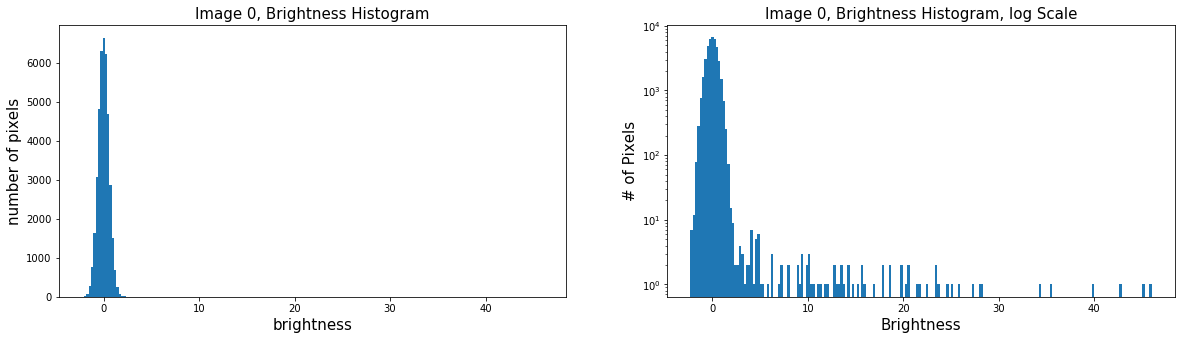

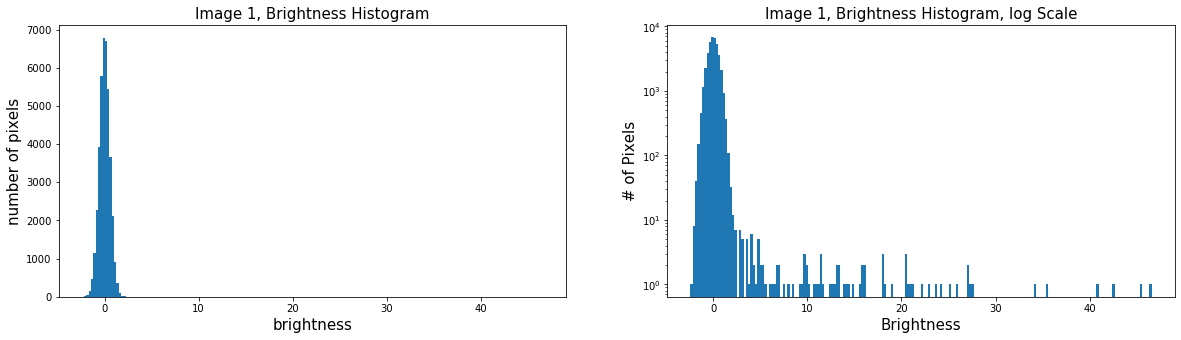

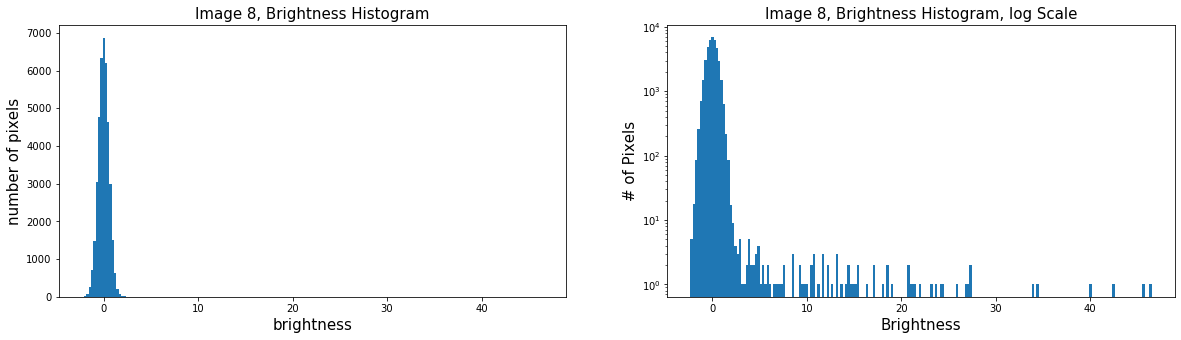

In [16]:
image_hist(0)
image_hist(1)
image_hist(8)


Above are 3 brightness histograms of images 0, 2, and 8 (I count the linear scale and the log scale histograms for the same image as one plot). The three plots look very similar. Each of the three histograms has a large peak centered at zero with a width of about 2. To the right of the large peak, there are many small peaks that are orders of magnitudes smaller than the large peak. The large peak should be from the background, and the small peaks with larger brightnesses are most likely stars. The histograms of the other 7 images also have the same pattern so are not shown here.

Below I will assume the histogram of brightnesses of any subsets of pixels in the 10 images would follow this pattern (Large peak near zero as background, much smaller peaks to the right as stars).

Assuming that the data follows this pattern and assuming the backgrounds are Gaussians, I decided to use the following scheme to calculate the parameters (mean and standard deviation) of background in any given data:

1. Calculate approximate values of mean and SD assuming all given data is background
2. Use the approximate mean and SD found to calculate (mean + 4 * SD), discard all the data larger than this, and calculate the mean and SD again
3. Repeat Step 2 one or more times

Since the background is a Gaussian, I would expect about (1-stats.norm.cdf(-4)) = 0.003% of the actual background to be discarded, which should have negligible influence on the calculation.

Implement the scheme:

In [20]:
def background(data,sigmas=4,repeat=3):
    data = data.flatten()
    mean = np.mean(data)
    sd = np.std(data)    
    for i in range(0,repeat):
        data = data[(data < mean + sigmas*sd)]
        mean = np.mean(data)
        sd = np.std(data)
    return mean,sd

Use the function on all 10 images with different times of repeat:

In [21]:
for i in [0,1,2,3,10]:
    print("Repeat %d times, (mean, sd)=%s" % (i, str(background(imagestack,repeat=i))))

Repeat 0 times, (mean, sd)=(0.033443765403738966, 0.9908593845236434)
Repeat 1 times, (mean, sd)=(0.002036926968946202, 0.565763620014493)
Repeat 2 times, (mean, sd)=(0.0005226852382087081, 0.5616978600657336)
Repeat 3 times, (mean, sd)=(0.0004944264040469676, 0.5616446615248968)
Repeat 10 times, (mean, sd)=(0.0004944264040469676, 0.5616446615248968)


The result looks stable after 3 times of repeat, So I will choose repeat=3 in further uses.


To see if the background is time dependent or consistent spatially, I selected nine evenly spaced 20*20 block on each image and calculated the background mean and sd inside these blocks using the above function. Below is a plot showing the result from Image 0 to 3.

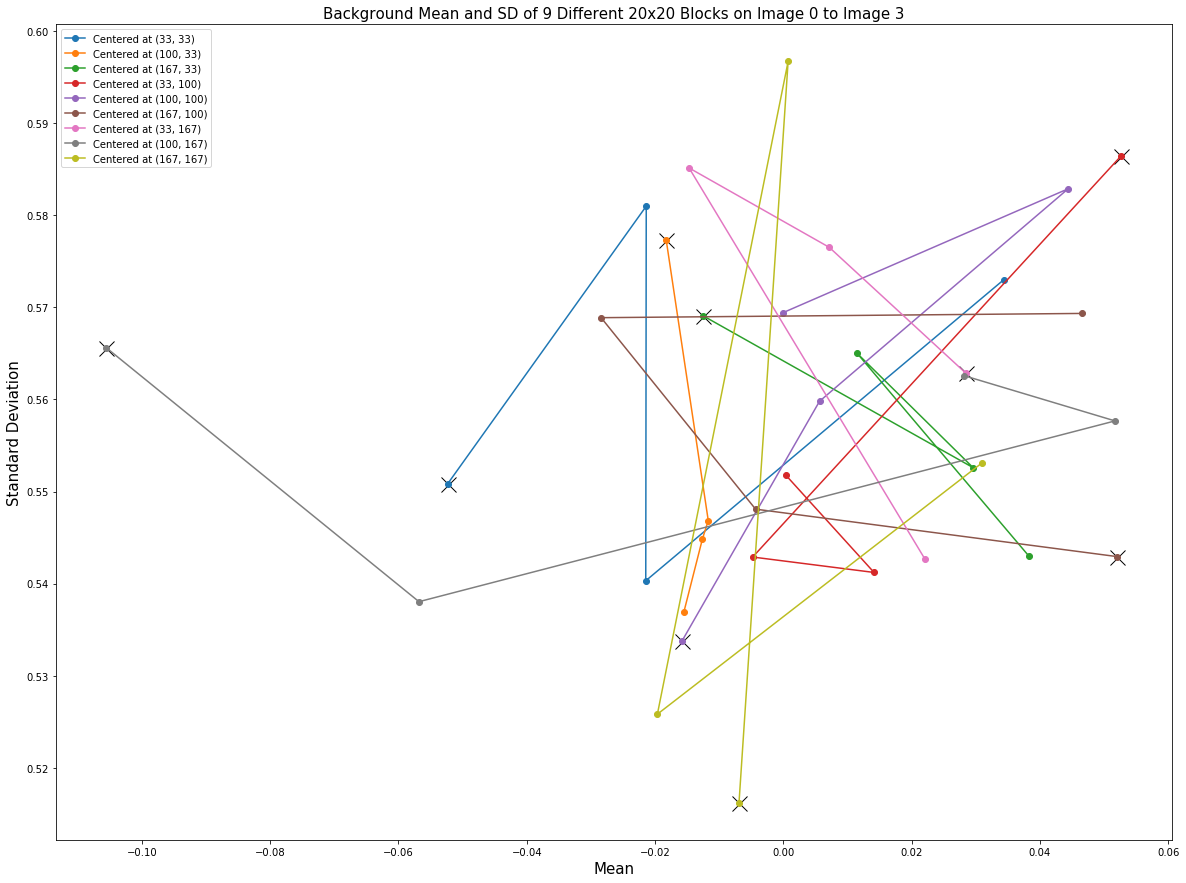

In [28]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
x = np.array([[33,100,167]]*3)
y = x.transpose().flatten()
x = x.flatten()
block_size = 20
for i in range(0,len(x)):
    d = int(block_size/2)
    mean = np.array([0.]*4)
    sd = np.array([0.]*4)
    for j in range(0,4):
        data = imagestack[x[i]-d:x[i]+d,y[i]-d:y[i]+d,j]
        mean[j],sd[j] = background(data,repeat=3)
    label = "Centered at (%d, %d)" % (x[i], y[i])
    ax.plot(mean[0],sd[0],'kx',markersize=15)
    ax.plot(mean,sd,'.-',markersize=12, label=label)
ax.legend()
ax.set_xlabel("Mean",fontsize = 15)
ax.set_ylabel("Standard Deviation",fontsize = 15)
ax.set_title("Background Mean and SD of %d Different %dx%d Blocks on Image 0 to Image 3" % (len(x),block_size,block_size),fontsize = 15)
plt.show()

Each color above represent a different region on the image as specified by the legend. The "x" marks represent the result from Image 0, and each subsequent dot on the line connected to the "x" represents the result of the next image, up to Image 3.

To see if the result is time dependent, we would see if there is any pattern in the locations of the dots on one line, and see also if this pattern is repeatable on other colored lines. To examin spatial dependence of the background, we would look at the n-th dot (by choosing any n from 0 to 3) on the nine different lines and see if there is any relationship between the relative locations of these dots on the above plot and the dots' physical locations on the corresponding image. 

For me, the dots in the above plot looks random, and I don't see any pattern in the relative locations of the dots. In addition, looking at the axis of the plot, we can see the dots' mean and standard deviation values have ranges of about 0.15 and 0.1, which is rather small as compared to the standard deviation value of about 0.5. Thus there doesn't seem to be any time or spatial dependence in the background.  

Knowing that the background (which I will later refer to as the global background) is consistant in time and space, it's now safe to calculate it using the data from all 10 images:

In [23]:
bkgd_mean,bkgd_sd = background(imagestack)
print("The background is a Gaussian with mean=%f, SD=%f" % (bkgd_mean, bkgd_sd))
#for i in range(0,10):
#    print(background(imagestack[:,:,i]))

The background is a Gaussian with mean=0.000494, SD=0.561645


Now, to find a transiant in the 200\*200\*10=400000 pixels, we first need to determin what significance level of discovery we want. To achieve a 5-sigma detection, we first need to discard the pixels with brightnesses lower than n time the SD of background, where

In [24]:
n_sd = stats.norm.ppf(1-(1-stats.norm.cdf(5))/400000)
print("n = %f." % n_sd)

n = 7.080795.


Next, for each of the pixels left, we need to compare this pixel to the other nine pixels located at the same location in the other 9 images. If the pixel does correspond to a transient, then its brightness should be from a different population distribution than that of the other 9 pixels' brightnesses, which I will refer to as the "local background". The mean of the local background can be approximated by calculating the mean of the nine points' brightnesses. The standard deviation of the local background may be equal to or higher than the global background depending on wheter or not the pixel is on a star. I will approximate this standard deviation by that of the golbal background, which is SD = 0.561645 as I calculated above. To achieve a 5-sigma detection, we need the the brightness of the pixel we are looking at to be m\*SD higher than the mean of its local background, where 

In [25]:
m_sd = stats.norm.ppf(1-(1-stats.norm.cdf(5))/10)
print("m = %f." % m_sd)

m = 5.426934.


I then wrote code to implement this but didn't find any result with the 5-sigma threshold. So I lowered the threshold to 3-sigma and found two possible transients:

In [26]:
sigmas = 3
n_sd = stats.norm.ppf(1-(1-stats.norm.cdf(sigmas))/400000)
m_sd = stats.norm.ppf(1-(1-stats.norm.cdf(sigmas))/10)

for i in range(0,200):
    for j in range(0, 200):
        for k in range(0,10):
            brightness = imagestack[i,j,k]
            if brightness < bkgd_sd*n_sd:
                continue
            bkgd = np.delete(imagestack[i,j,:], k)
            mean = np.mean(bkgd)
            if brightness > mean + m_sd * bkgd_sd:
                sig = -stats.norm.ppf( (1-stats.norm.cdf((brightness - mean)/bkgd_sd))*10 )
                print("Possible transient at (x,y)=(%d,%d) on Image %d; brightness = %f, local background brightness = %f; significance of discovery: %.1f-sigma." % (i,j,k,brightness,mean,sig))

Possible transient at (x,y)=(17,52) on Image 5; brightness = 12.461414, local background brightness = 10.136523; significance of discovery: 3.6-sigma.
Possible transient at (x,y)=(101,25) on Image 1; brightness = 22.983598, local background brightness = 20.867283; significance of discovery: 3.1-sigma.


The pixel at (x,y)=(17,52) on Image 5 is more likely to correspond to a transient since it has a higer "sigmas" value. However, none of the two pixels I found reach 5-sigma, so I may not be able to claim a discovery.

My partner is looking for the faintest stars. My partner and I are have different background PDFs becasue we are looking for different things and thus calculating background within different subsets of the data. Transient events are time-dependent, so I need to look at subsets of the data acorss different images and calculate the background withind those subsets. On the other hand, brightness of the stars are rather independent of time, so my partner only needs to calculate the background in individual images or average of images.